In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sn
import pandas as pd

### CIFAR10 Dataset

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
default_batch_size = 32
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
if use_cuda:
    loader_args.update({'pin_memory' : True, 'num_workers' : 1})

In [4]:
trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = utils.data.DataLoader(trainset, **loader_args)
testset  = datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.ToTensor())
test_loader  = utils.data.DataLoader(testset, **loader_args)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
image_size = trainset[0][0].size()
image_size

torch.Size([3, 32, 32])

In [6]:
input_channel_size = 3
input_image_size = 32
label_size = 10

### CIFAR10 CNN Model

In [7]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, ichannel_size, isize, osize):
        super(CIFAR10Classifier, self).__init__()
        fc1_size = int(((math.floor((math.floor((isize - 2) / 2) - 2) / 2) ** 2) * 64))
        self.conv1 = nn.Conv2d(ichannel_size, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(fc1_size, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, osize)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
model_file = '../models/cifar10_classifier.pt'
model = CIFAR10Classifier(input_channel_size, input_image_size, label_size)
model = model.to(device)

### Training

In [7]:
from abc import ABC, abstractmethod

class StatsCollector(ABC):
    @abstractmethod
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        pass
    @abstractmethod
    def eval_gather(self, train_epoch, loss, accuracy):
        pass
    @abstractmethod
    def eval_pred_gather(self, train_epoch, predictions, targets):
        pass
    @abstractmethod
    def train_reset(self):
        pass
    @abstractmethod
    def eval_reset(self):
        pass

class FrequentLossCollector(StatsCollector):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if (epoch * (dataset_size / self.batch_size) + batch_idx) % self.frequency == 0:
            self.losses.append((epoch, batch_idx, dataset_size, loss))
        if report_frequency > 0 and (epoch * (dataset_size / self.batch_size) + batch_idx) % self.report_frequency == 0:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

class EpochLossCollector(StatsCollector):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

In [8]:
def train(model, device, loader, optimizer, loss, epoch, collector):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        collector.train_gather(epoch, batch_idx, len(loader.dataset), l.item())

In [9]:
def validate(model, device, loader, loss, train_epoch, collector):
    model.eval()
    total_loss = 0.
    total_corrects = 0.
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            collector.eval_pred_gather(train_epoch, pred, target)
            corrects = pred.eq(target.view_as(pred)).sum().item()
            total_corrects += corrects
    total_loss /= len(loader.dataset)
    accuracy = total_corrects / len(loader.dataset)
    collector.eval_gather(train_epoch, total_loss, accuracy)

In [10]:
def train_validate(model, device, train_loader, test_loader, optimizer, loss, collector, total_epoch):
    for epoch in range(total_epoch):
        train(model, device, train_loader, optimizer, loss, epoch, collector)
        validate(model, device, test_loader, loss, epoch, collector)

In [13]:
learning_rate = 0.0001
total_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.NLLLoss()
collector = EpochLossCollector(default_batch_size, 1, 1)

In [14]:
for i in range(total_epochs):
    train(model, device, train_loader, optimizer, loss, i, collector)

Epoch 0, 49984/50000: 1.5542114973068237
Epoch 1, 49984/50000: 1.7739551067352295
Epoch 2, 49984/50000: 1.1842297315597534
Epoch 3, 49984/50000: 1.2813622951507568
Epoch 4, 49984/50000: 0.960485577583313
Epoch 5, 49984/50000: 1.4895951747894287
Epoch 6, 49984/50000: 1.5221526622772217
Epoch 7, 49984/50000: 1.1810797452926636
Epoch 8, 49984/50000: 0.7654122114181519
Epoch 9, 49984/50000: 1.3909032344818115


### Validate

In [15]:
validate(model, device, test_loader, loss, total_epochs, collector)

In [16]:
collector.eval_losses

[(20, 0.03027514417171478, 0.6611)]

### Saving Model

In [17]:
torch.save(model, model_file)

### Prediction Result

In [11]:
def predict(model, device, loader):
    model.eval()
    inputs = np.empty((0,input_channel_size,input_image_size,input_image_size))
    predictions = np.empty(0)
    targets = np.empty(0)
    with torch.no_grad():
        for data, target in loader:
            inputs = np.concatenate((inputs, data), axis=0)
            data = data.to(device)
            output = model(data)
            prediction = output.argmax(dim=1)
            prediction = prediction.cpu()
            targets = np.concatenate((targets, target), axis=0)
            predictions = np.concatenate((predictions, prediction), axis=0)
    return (predictions, targets, inputs)

In [12]:
def predictions_to_matrix(predictions, targets, n_classes):
    mtx = [[0 for i in range(n_classes)] for i in range(n_classes)]
    for i in range(len(predictions)):
        mtx[int(predictions[i])][int(targets[i])] += 1
    return mtx

In [21]:
predictions, targets, inputs = predict(model, device, test_loader)
confusion_matrix = predictions_to_matrix(predictions, targets, label_size)

<AxesSubplot:>

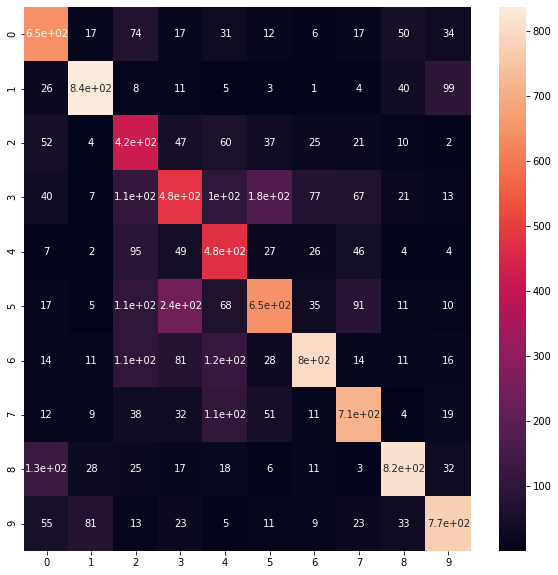

In [24]:
df = pd.DataFrame(confusion_matrix, index=[i for i in range(label_size)], columns=[i for i in range(label_size)])
plt.figure(figsize=(10, 10))
sn.heatmap(df, annot=True)

In [13]:
tensor2image = transforms.ToPILImage()

In [14]:
def incorrect(predictions, targets, inputs):
    ret = []
    for i, (pred, targ) in enumerate(zip(predictions, targets)):
        if pred != targ:
            ret.append((i, targ, pred, inputs[i]))
    return ret

In [27]:
incorrects = incorrect(predictions, targets, inputs)

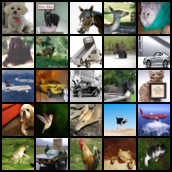

In [30]:
sample_idxes = [random.randint(0, len(incorrects) - 1) for _ in range(25)]
incorrect_images = np.empty((0,input_channel_size,input_image_size,input_image_size))
for i in sample_idxes:
    incorrect_images = np.concatenate((incorrect_images, np.expand_dims(incorrects[i][3], axis=0)), axis=0)
incorrect_images = torch.from_numpy(incorrect_images)
incorrect_image_grid = torchvision.utils.make_grid(incorrect_images, nrow=5)
tensor2image(incorrect_image_grid)

In [32]:
sample_idx = random.randint(0, len(incorrects) - 1)
incorrect_image = torch.from_numpy(incorrects[sample_idx][3]).type(torch.FloatTensor)

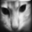

In [33]:
tensor2image(incorrect_image)

In [34]:
print("Correct Label: {} Prediction Label: {}".format(incorrects[sample_idx][1], incorrects[sample_idx][2]))

Correct Label: 3.0 Prediction Label: 5.0


#### Label Annotation
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

### Transfer Learning with VGG16 Network

In [11]:
class CIFAR10_VGG16BN(nn.Module):
    def __init__(self, osize):
        super(CIFAR10_VGG16BN, self).__init__()
        self.vgg16 = models.vgg16_bn(pretrained=True)
        # lock original network layers
        for param in self.vgg16.parameters():
            param.requires_grad = False
        # shorten the convolutional network, this is necessary
        # to make the network more suitable for CIFAR10
        new_features = []
        for i in range(3 * 7 + 3):
            new_features.append(self.vgg16.features[i])
        self.vgg16.features = nn.Sequential(*new_features)
        # replace the classifier with a smaller layer too
        # because CIFAR10 does not need as many features
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.Dropout(0.5),
            nn.Linear(256, osize),
            nn.LogSoftmax(dim=1)
        )
        # make sure the new layers are trainable
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self.vgg16(x)
        return x

In [12]:
vgg16_model = CIFAR10_VGG16BN(label_size)
vgg16_model = vgg16_model.to(device)

In [13]:
vgg16_learning_rate = 0.0001
vgg16_total_epochs = 10
vgg16_optimizer = optim.Adam(vgg16_model.parameters(), lr=vgg16_learning_rate)
vgg16_loss = nn.NLLLoss()
vgg16_collector = EpochLossCollector(default_batch_size, 1, 1)

In [14]:
for i in range(vgg16_total_epochs):
    train(vgg16_model, device, train_loader, vgg16_optimizer, vgg16_loss, i, vgg16_collector)

Epoch 0, 49984/50000: 0.41474857926368713
Epoch 1, 49984/50000: 0.7783827781677246
Epoch 2, 49984/50000: 0.5099256634712219
Epoch 3, 49984/50000: 0.35317856073379517
Epoch 4, 49984/50000: 0.8231353163719177
Epoch 5, 49984/50000: 0.3071891665458679
Epoch 6, 49984/50000: 0.1979789286851883
Epoch 7, 49984/50000: 0.43552544713020325
Epoch 8, 49984/50000: 0.43644949793815613
Epoch 9, 49984/50000: 0.28856876492500305


In [15]:
validate(vgg16_model, device, test_loader, vgg16_loss, vgg16_total_epochs, vgg16_collector)

In [16]:
print("transfer learning validation accuracy: {}".format(vgg16_collector.eval_losses[0][2]))

transfer learning validation accuracy: 0.8426


### Train VGG16 From Scratch on CIFAR10

In [11]:
vgg16 = models.vgg16_bn(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, label_size)
vgg16 = vgg16.to(device)

In [12]:
vgg16_learning_rate = 0.0001
vgg16_total_epochs = 10
vgg16_optimizer = optim.Adam(vgg16.parameters(), lr=vgg16_learning_rate)
vgg16_loss = nn.CrossEntropyLoss()
vgg16_collector = EpochLossCollector(default_batch_size, 1, 1)

In [13]:
for i in range(vgg16_total_epochs):
    train(vgg16, device, train_loader, vgg16_optimizer, vgg16_loss, i, vgg16_collector)

Epoch 0, 49984/50000: 0.691571056842804
Epoch 1, 49984/50000: 0.34367257356643677
Epoch 2, 49984/50000: 0.7274443507194519
Epoch 3, 49984/50000: 0.2615000605583191
Epoch 4, 49984/50000: 0.2706305980682373
Epoch 5, 49984/50000: 0.02183365263044834
Epoch 6, 49984/50000: 0.07468290627002716
Epoch 7, 49984/50000: 0.30984196066856384
Epoch 8, 49984/50000: 0.5883130431175232
Epoch 9, 49984/50000: 0.0030811706092208624


In [14]:
validate(vgg16, device, test_loader, vgg16_loss, vgg16_total_epochs, vgg16_collector)

In [15]:
vgg16_collector.eval_losses

[(10, 0.01508800828102976, 0.8865)]